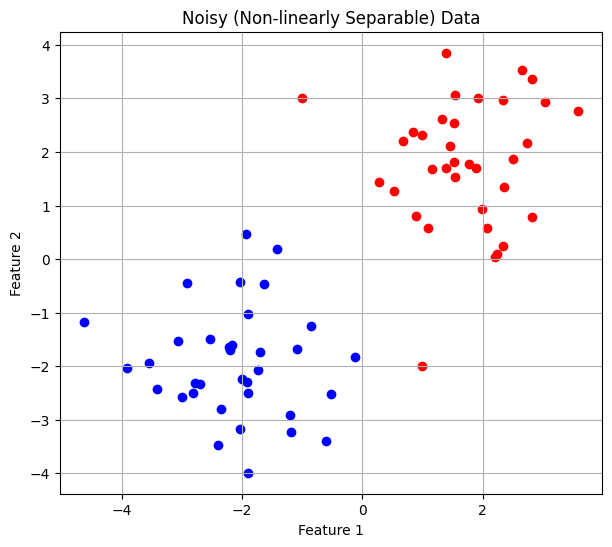

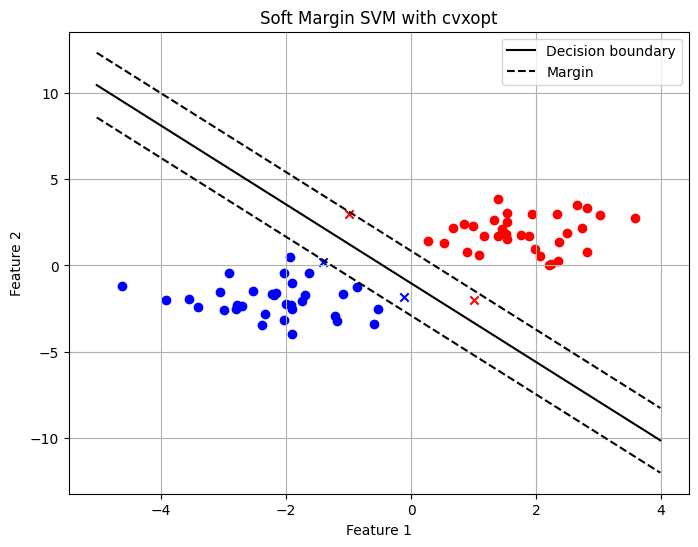

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# --- Generate Non-perfectly Separable Dataset ---
np.random.seed(42)
X_pos = np.random.randn(35, 2) + [2, 2]
X_neg = np.random.randn(35, 2) + [-2, -2]
X = np.vstack((X_pos, X_neg))
y = np.hstack((np.ones(35), -1 * np.ones(35)))

# Add noise to make it non-separable
X[10] = [-1, 3]
X[25] = [1, -2]

# --- Plot Function ---
def plot_data(X, y):
    plt.figure(figsize=(7, 6))
    for i in range(len(y)):
        color = 'r' if y[i] == 1 else 'b'
        plt.scatter(X[i][0], X[i][1], color=color)
    plt.title("Noisy (Non-linearly Separable) Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

plot_data(X, y)

import numpy as np
from cvxopt import matrix, solvers

def soft_margin_svm(X, y, C=1.0):
    n_samples, n_features = X.shape

    # Compute the Gram matrix: K[i,j] = x_i . x_j
    K = np.dot(X, X.T)

    # Define the parameters for the QP solver
    P = matrix(np.outer(y, y) * K)         # shape: (n_samples, n_samples)
    q = matrix(-1 * np.ones(n_samples))    # shape: (n_samples, )
    G_std = np.diag(-1 * np.ones(n_samples))
    h_std = np.zeros(n_samples)

    G_slack = np.identity(n_samples)
    h_slack = np.ones(n_samples) * C

    G = matrix(np.vstack((G_std, G_slack)))   # shape: (2*n_samples, n_samples)
    h = matrix(np.hstack((h_std, h_slack)))   # shape: (2*n_samples, )

    A = matrix(y.astype(float), (1, n_samples))
    b = matrix(0.0)

    # Solve QP problem
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])

    # Support vectors have non-zero lagrange multipliers
    sv = (alpha > 1e-5)
    alpha_sv = alpha[sv]
    X_sv = X[sv]
    y_sv = y[sv]

    # Compute w
    w = np.sum(alpha_sv[:, np.newaxis] * y_sv[:, np.newaxis] * X_sv, axis=0)

    # Compute b using any support vector
    b = np.mean([y_k - np.dot(w, x_k) for (x_k, y_k) in zip(X_sv, y_sv)])

    return w, b, alpha, sv

w, b, alpha, sv = soft_margin_svm(X, y, C=1.0)

# Plot decision boundary
def plot_decision_boundary(X, y, w, b, sv):
    plt.figure(figsize=(8, 6))
    for i in range(len(y)):
        color = 'r' if y[i] == 1 else 'b'
        plt.scatter(X[i][0], X[i][1], color=color, marker='o' if not sv[i] else 'x')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = (-w[0] * xx - b) / w[1]

    # Margin lines
    margin = 1 / np.linalg.norm(w)
    yy_down = yy - np.sqrt(1 + (w[0]/w[1])**2) * margin
    yy_up = yy + np.sqrt(1 + (w[0]/w[1])**2) * margin

    plt.plot(xx, yy, 'k-', label='Decision boundary')
    plt.plot(xx, yy_down, 'k--', label='Margin')
    plt.plot(xx, yy_up, 'k--')

    plt.title("Soft Margin SVM with cvxopt")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_decision_boundary(X, y, w, b, sv)


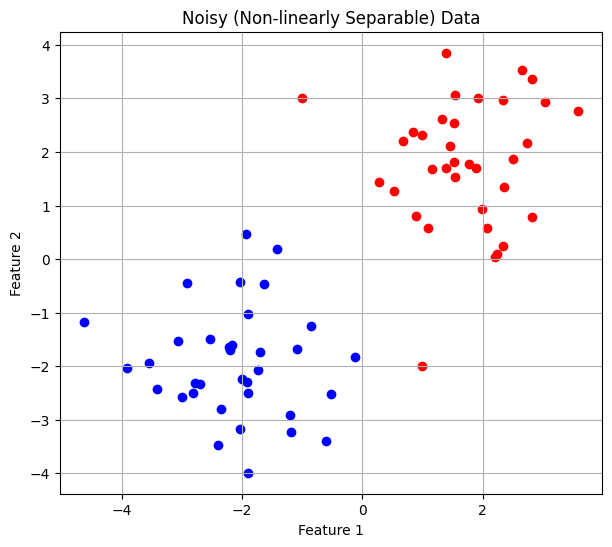

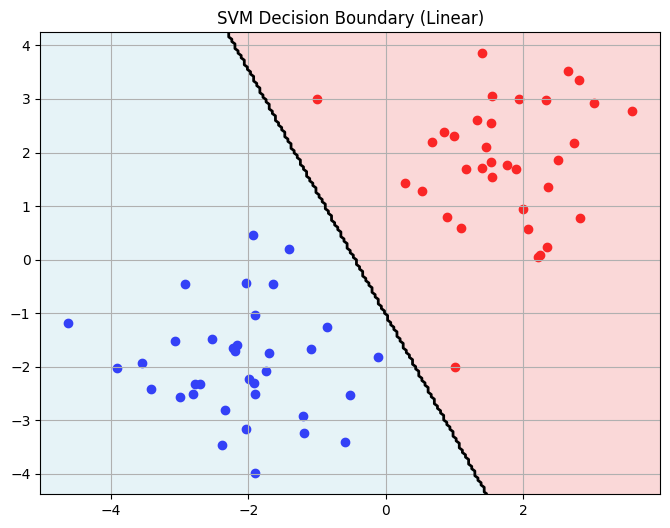

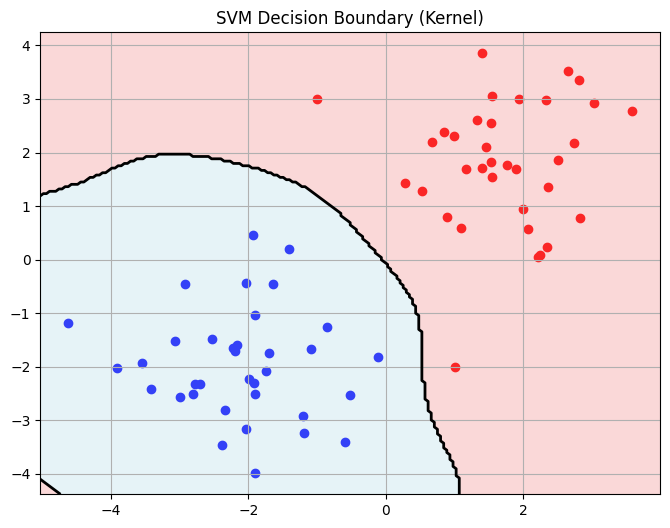

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# --- Generate Non-perfectly Separable Dataset ---
np.random.seed(42)
X_pos = np.random.randn(35, 2) + [2, 2]
X_neg = np.random.randn(35, 2) + [-2, -2]
X = np.vstack((X_pos, X_neg))
y = np.hstack((np.ones(35), -1 * np.ones(35)))

# Add noise to make it non-separable
X[10] = [-1, 3]
X[25] = [1, -2]

# --- Plot Function ---
def plot_data(X, y):
    plt.figure(figsize=(7, 6))
    for i in range(len(y)):
        color = 'r' if y[i] == 1 else 'b'
        plt.scatter(X[i][0], X[i][1], color=color)
    plt.title("Noisy (Non-linearly Separable) Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

plot_data(X, y)

import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# --- Kernels ---
def linear_kernel(X1, X2):
    return np.dot(X1, X2.T)

def rbf_kernel(X1, X2, gamma=0.5):
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + \
               np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)

def soft_margin_svm(X, y, C=1.0, use_kernel=False, kernel_fn=rbf_kernel, gamma=0.5):
    n_samples = X.shape[0]

    # Compute kernel or linear Gram matrix
    if use_kernel:
        K = kernel_fn(X, X, gamma=gamma) if kernel_fn == rbf_kernel else kernel_fn(X, X)
    else:
        K = linear_kernel(X, X)

    # QP parameters
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)]))
    h = matrix(np.hstack([np.zeros(n_samples), np.ones(n_samples) * C]))
    A = matrix(y.reshape(1, -1).astype(float))
    b = matrix(0.0)

    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(sol['x'])

    sv = alpha > 1e-5
    alpha_sv = alpha[sv]
    X_sv = X[sv]
    y_sv = y[sv]

    if use_kernel:
        K_sv = kernel_fn(X_sv, X_sv, gamma=gamma) if kernel_fn == rbf_kernel else kernel_fn(X_sv, X_sv)
        b = np.mean([y_sv[i] - np.sum(alpha_sv * y_sv * K_sv[i]) for i in range(len(alpha_sv))])
        return alpha_sv, X_sv, y_sv, b, use_kernel, kernel_fn, gamma
    else:
        # Linear case
        w = np.sum(alpha_sv[:, np.newaxis] * y_sv[:, np.newaxis] * X_sv, axis=0)
        b = np.mean([y_k - np.dot(w, x_k) for x_k, y_k in zip(X_sv, y_sv)])
        return w, b, alpha, sv, use_kernel

def predict(X_test, model):
    if model[-1]:  # use_kernel == True
        alpha_sv, X_sv, y_sv, b, _, kernel_fn, gamma = model
        K = kernel_fn(X_test, X_sv, gamma=gamma) if kernel_fn == rbf_kernel else kernel_fn(X_test, X_sv)
        return np.sign(np.dot(K, alpha_sv * y_sv) + b)
    else:
        w, b, _, _, _ = model
        return np.sign(np.dot(X_test, w) + b)

def plot_decision_boundary(X, y, model):
    plt.figure(figsize=(8, 6))
    for i in range(len(y)):
        plt.scatter(X[i, 0], X[i, 1], c='r' if y[i] == 1 else 'b', marker='o')

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, 200), np.linspace(*ylim, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict(grid, model).reshape(xx.shape)

    # Fill class regions with color
    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['lightblue', 'lightcoral'], alpha=0.3)

    # Draw only the decision boundary (f(x) = 0)
    plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)

    plt.title("SVM Decision Boundary" + (" (Kernel)" if model[-1] else " (Linear)"))
    plt.grid(True)
    plt.show()

model = soft_margin_svm(X, y, C=1.0, use_kernel=False)
plot_decision_boundary(X, y, model)

model = soft_margin_svm(X, y, C=1.0, use_kernel=True, kernel_fn=rbf_kernel, gamma=0.5)
plot_decision_boundary(X, y, model)